<a href="https://colab.research.google.com/github/AMIRMOHAMMAD-OSS/Bioinformatics/blob/main/phase_seperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liquid-Liquid Phase Separation (LLPS) Protein Scorer!

This tool allows you to analyze protein sequences for their propensity to undergo phase separation:

Input Options:
Upload a single protein sequence directly into the designated box.
Alternatively, load a FASTA or TXT file containing multiple protein sequences.

To maintain efficiency, we advise against loading more than 100 sequences at once

Specify the sequence ID or directory for your analysis.

By setting the 'End_Sequence'  parameter,you can focus the scoring on sequences up to the specified endpoint.

         



#BLAST+ tool
You can utilize the BLAST+ tool to run ncbi BLAST searches on either your protein sequence or your FASTA file against your dataset. This powerful tool allows you to compare sequences and identify homologous regions, aiding in various biological analyses.


In [ ]:
#@title Importing libraries
from google.colab import output
!git clone https://github.com/AMIRMOHAMMAD-OSS/classi
output.clear()
!pip install biopython
output.clear()
!apt-get update
!apt-get install -y ncbi-blast+
!pip install streamlit
output.clear()

!pip install py3Dmol
output.clear()
!pip install requests
!pip install biotite
!pip install stmol
output.clear()
!pip install command_runner
output.clear()
from command_runner import command_runner
!pip install plotly
!pip install --upgrade "kaleido==0.1.*"
output.clear()
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import pairwise2
from google.colab import files
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import zipfile
import shutil
from transformers import AutoTokenizer
from tqdm import tqdm
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import time
from collections import defaultdict
import torch
from torch.utils.data.dataloader import DataLoader
import time
import os
import sys
import json
import random
from ast import literal_eval
import numpy as np
import torch
from transformers import AutoTokenizer
from transformers import AutoTokenizer
from tokenizers import Tokenizer, decoders, models, normalizers, pre_tokenizers, trainers
from transformers import CanineTokenizer, CanineModel
tokenizer = Tokenizer.from_file("classi/Trained_BPE2.json")
tokenizer.model_max_length = 256
tokenizer

from sklearn.preprocessing import StandardScaler as Sc
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as TTS
import numpy as np

import torch

from sklearn.model_selection import train_test_split as TTS


def edit(x):
    for i in x:
      if i in "BJOUX\Z_n\n":
        x = x.replace(i,"")
      else:
        pass
    return x

def encode(x):
  l = []
  chars = tokenizer.get_vocab()
  for i in x:
    l.append(chars[i])
  return l

with open("classi/training.txt","r",encoding="utf-8") as f:
  text = f.read()
  k = "#".join([i for i in edit(text).split("<|edoftext|>")])
chars = tokenizer.get_vocab()
vocab_size = len(tokenizer.get_vocab())

with open("classi/validation.txt","r",encoding="utf-8") as f:
  text = f.read()
  l = "#".join([i for i in edit(text).split("<|edoftext|>")])

def Padding(x,PAD = 0,max_len = 512):
  l = []
  max_len = max(512,len(max(x,key = lambda x: len(x))))
  for i in x:
    a = i
    if len(a) < max_len:
      a = a + [PAD for i in range(max_len-len(a))]
    l.append(a)
  return np.array(l).reshape(len(x),max_len)
with open("classi/negative_dataset.txt") as x:
  c = x.read()
Filtered_train  = [i for i in k.split("#") if len(i)<= 512][1:]
Filtered_val = [i for i in l.split("#") if len(i)<= 512][1:]
Filtered_neg = [i for i in c.split("\n") if len(i)<= 512]
pos = Filtered_train + Filtered_val
pos2 = list(set([i for i in k.split("#")][1:] +  [i for i in l.split("#")][1:]))
with open("DrLLPS.fasta","w") as w:
  for i in range(len(pos2)):
    w.write(">seq{i}\n".format(i=i))
    w.write(pos2[i]+"\n")
  w.close()
files.download("DrLLPS.fasta")
output.clear()
#@title RR
from tqdm import tqdm
from multiprocessing import Pool
from Bio import SeqIO
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
import pandas as pd
import numpy as np
from scipy.io import loadmat
!unzip /content/classi/neg_feature_extracted_dataset.zip
!unzip /content/classi/pos_feature_extracted_Oversampled_dataset.zip
output.clear()

n1 = pd.read_csv("classi/neg_feature_extracted_dataset(512_).csv")
n2 = pd.read_csv("/content/neg_feature_extracted_dataset.csv")
p1 = pd.read_csv("classi/pos_feature_extracted_dataset(512_).csv")
p2 = pd.read_csv("/content/pos_feature_extracted_Oversampled_dataset.csv")

def EDIT(s):
  R = []
  for i in s:
    i = i[1:i.index("j")-2]
    if i == "":
      i = float(0)
    else:
      i = float(i)
    R.append(i)
  return np.array(R).reshape(1,578)
p1 = np.array([EDIT(i) for i in p1.iloc[:,1:].values.tolist()]).reshape(-1,578)
p2 = np.array([EDIT(i) for i in p2.iloc[:,1:].values.tolist()]).reshape(-1,578)
n1 = np.array([EDIT(i) for i in n1.iloc[:,1:].values.tolist()]).reshape(-1,578)
n2 = np.array([EDIT(i) for i in n2.iloc[:,2:].values.tolist()]).reshape(-1,578)
def coordinate():
    pt = [np.array([np.cos(i * 2 * np.pi / 20), np.sin(i * 2 * np.pi / 20), 1]) for i in range(20)]
    P = np.vstack(pt)
    V = [[pt[i] + (1 / 20) * (pt[j] - pt[i]) for j in range(20)] for i in range(20)]
    return P, V


def FEGS(sequences):
    P, V = coordinate()
    #sequences = [str(record.seq) for record in SeqIO.parse(f"{data}.fasta", "fasta")]
    l = len(sequences)

    with Pool() as pool:
        g_p = pool.starmap(GRS, [(seq, P, V) for seq in sequences])
        EL = np.array([ME(i) for i in  [g for g_list in g_p for g in g_list]]).reshape(l,158)

    char = 'ARNDCQEGHILKMFPSTWYV'
    with Pool() as pool:
        results = pool.map(SAD, [(seq, char) for seq in sequences])
        FA = np.array([res[0] for res in results])
        FD = np.array([res[1].flatten() for res in results])

    FV = np.hstack((EL, FA, FD))
    return FV


def GRS(seq, P, V):
    M = loadmat("/content/classi/M.mat")
    M = M["M"].flatten()
    l_seq = len(seq)
    k = M.shape[0]
    cha = 'ACDEFGHIKLMNPQRSTVWY'
    g = []

    for j in range(k):
        DPC = np.zeros((20, 20))
        c = [[0, 0, 0]]
        d = np.zeros(3)
        y = None

        for i in range(l_seq):
            x = np.array([seq[i] == aa for aa in M[j]]).astype(int)
            if i == 0:
                c.append(c[i] + np.dot(x, P))
            else:
                if not np.any(x):
                    d = d * (i - 1) / i
                    c.append(c[i] + [0, 0, 1] + d)
                elif not np.any(y):
                    d = d * (i - 1) / i
                    c.append(c[i] + np.dot(x, P) + d)
                else:
                    d = d * (i - 1) / i + V[int(np.where(y)[0][0])][int(np.where(x)[0][0])] / i
                    c.append(c[i] + np.dot(x, P) + d)
            y = x

        g.append(np.vstack(c))
    return g

def ME(W):
    W = W[1:, :]
    x = W.shape[0]
    D = pdist(W)
    E = squareform(D)
    sdist = np.zeros((x, x))

    for i in range(x):
        for j in range(i, x):
            if j - i == 1:
                sdist[i, j] = E[i, j]
            elif j - i > 1:
                sdist[i, j] = sdist[i, j - 1] + E[j - 1, j]

    sdist += sdist.T
    sdd = sdist + np.diag(np.ones(x))
    L = E / sdd
    ME = eigs(L, k=1)[0][0] / x
    return ME

def SAD(args):
    seq, a = args
    len_seq = len(seq)
    len_a = len(a)
    AAC = np.zeros(len_a)
    DPC = np.zeros((len_a, len_a))

    c = [np.array([s == aa for s in seq]) for aa in a]
    AAC = np.array([np.sum(c[i]) / len_seq for i in range(len_a)])

    if len_seq != 1:
        for i in range(len_a):
            for j in range(len_a):
                DPC[i, j] = np.sum((np.roll(c[j], -1) * 2 - c[i]) == 1) / (len_seq - 1)
    return AAC, DPC

from sklearn.model_selection import train_test_split
Data = np.concatenate((p2,p1,n2,n1))
labels = np.concatenate((np.ones(p2.shape[0]),np.ones(p1.shape[0]),np.zeros(n2.shape[0]),np.zeros(n1.shape[0])))
train_data,test_data,train_l,test_l = train_test_split(Data,labels,test_size = 0.1,random_state = 48)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

r = RandomForestClassifier(n_estimators=100, random_state=48)
r.fit(train_data,train_l)
output.clear()

class RF():
  def __init__(self,seq):
    self.model = r
    self.seq = seq
  def TR(self):
    return FEGS(self.seq)
  def Model(self):
    return self.model
  def predict_proba(self):
    return self.model.predict_proba(self.TR().astype(np.float64))
print("Everything looks ok! ✨🍰✨")

Everything looks ok! ✨🍰✨


In [ ]:
#@title Loading models and requierments
if torch.cuda.is_available():
  print("Cuda is available 🎉\n")
  print("The allocated device is : "+torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  print("Cuda is not available 😔\n")
  print("The allocated device is : cpu")
  device = torch.device("cpu")



def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def setup_logging(config):
    work_dir = config.system.work_dir
    os.makedirs(work_dir, exist_ok=True)
    with open(os.path.join(work_dir, 'args.txt'), 'w') as f:
        f.write(' '.join(sys.argv))
    with open(os.path.join(work_dir, 'config.json'), 'w') as f:
        f.write(json.dumps(config.to_dict(), indent=4))

class CfgNode:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __str__(self):
        return self._str_helper(0)

    def _str_helper(self, indent):
        parts = []
        for k, v in self.__dict__.items():
            if isinstance(v, CfgNode):
                parts.append("%s:\n" % k)
                parts.append(v._str_helper(indent + 1))
            else:
                parts.append("%s: %s\n" % (k, v))
        parts = [' ' * (indent * 4) + p for p in parts]
        return "".join(parts)

    def to_dict(self):
        return { k: v.to_dict() if isinstance(v, CfgNode) else v for k, v in self.__dict__.items() }

    def merge_from_dict(self, d):
        self.__dict__.update(d)

    def merge_from_args(self, args):

        for arg in args:
            keyval = arg.split('=')
            assert len(keyval) == 2, "expecting each override arg to be of form --arg=value, got %s" % arg
            key, val = keyval
            try:
                val = literal_eval(val)
            except ValueError:
                pass

            assert key[:2] == '--'
            key = key[2:]
            keys = key.split('.')
            obj = self
            for k in keys[:-1]:
                obj = getattr(obj, k)
            leaf_key = keys[-1]
            assert hasattr(obj, leaf_key), f"{key} is not an attribute that exists in the config"
            print("command line overwriting config attribute %s with %s" % (key, val))
            setattr(obj, leaf_key, val)

import math
import torch
import torch.nn as nn
from torch.nn import functional as F

class SiLU(nn.Module):
   def forward(self, x):
        return x*F.sigmoid(x)

class NY(nn.Module):
  def forward(self,x):
    return 3*torch.tanh(0.3*x)

class NewGELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class ClassifierII(nn.Module):
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        C.vocab_size = len(chars)
        C.max_length = 512
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        self.max_length = config.block_size
        self.soft = nn.Softmax(1)
        self.config = self.get_default_config()
        self.device = "cuda"
        self.model_states = {'h':{'n_layer': 48, 'n_head': 25, 'n_embd': 1600},
                                    'g':{'n_layer': 12, '': 12, 'n_embd': 768},
                'f':   {'n_layer': 24, 'n_head': 16, 'n_embd': 1024},
                'e':   {'n_layer': 36, 'n_head': 20, 'n_embd': 1280},
                'd':{'n_layer': 8, 'n_head': 16, 'n_embd': 512},
                'c':{'n_layer': 6, 'n_head': 6, 'n_embd': 192},
                'b':{'n_layer': 4, 'n_head': 4, 'n_embd': 128},
                'a':{'n_layer': 3, 'n_head': 3, 'n_embd': 48}}

        type_ = config.model_type is not None
        #assert type_ in "abcdefgh"
        p = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        #assert type_ == True and p == True
        if type_:
            config.merge_from_dict(self.model_states[config.model_type])
        self.closs = nn.BCELoss()
        self.ny = NY()
        self.l = nn.Linear(512,1,64)
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.max_length, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),))
        self.classifier_head = nn.Sequential(#nn.Tanh(),
                                             nn.Linear(config.n_embd, 2)
                                             )
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("[ Number of trainable parameters: %.2fM ]" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        from transformers import GPT2LMHeadModel
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 25
        config.max_length = 512
        model = ClassifierII(config)
        sd = model.state_dict()
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

    def configure_optimizers(self, train_config):
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias'):
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    @torch.no_grad
    def predict_proba(self,idx,j ="None"):
      sigmoid = nn.Sigmoid()
      soft = nn.Softmax(dim=1)
      ny = NY()
      si = SiLU()
      self.eval()
      x,_ = self.forward(idx)
      if j == "None":
        return x[:,0:1]
      elif j == "soft":
        return self.soft(x)[:,0:1]
      else:
        return sigmoid(x)[:,0:1]

    @torch.no_grad
    def predict(self,idx):
      g = torch.zeros((idx.shape[0],1))
      e = -1
      for i in self.predict_proba(idx):
        e+=1
        if i[0].item()>=0.5:
          g[e] = 1
      return g

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.classifier_head(x).view(b,2,t).to(device)
        logits = self.l(logits)
        logits = F.sigmoid(self.ny(logits).view(b,2).mean(1).view(b,1))
        loss = None
        if targets is not None:
            loss = F.binary_cross_entropy(logits,targets)
        return logits, loss


class Trainer:
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.device = 'cuda'
        C.num_workers = 4
        C.max_iters = None
        C.batch_size = 128
        C.max_length = 512
        C.learning_rate = 8e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset,val_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.callbacks = defaultdict(list)
        self.device ='cuda'
        self.model = self.model.to(self.device)
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config
        self.optimizer = model.configure_optimizers(config)
        batch_size = self.config.batch_size
        def get_batch(mode):
            batch_size = 64
            if mode == "train":
              data = train_dataset
              pos_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]),513))
              neg_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]),513))
              N = np.random.randint(batch_size)
              ix_pos = np.random.randint(pos_train.shape[0]-N)
              ix_neg = np.random.randint(neg_train.shape[0]-batch_size-N)
              pos_data = pos_train[ix_pos:ix_pos+N,:]
              neg_data = neg_train[ix_neg:ix_neg+batch_size-N,:]
              data = torch.concat((pos_data,neg_data))
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,1), device="cuda")
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o] = 1
                #else:
                  #targets[o][1] = 1
            else:
              data = val_dataset
              ix = np.random.randint(data.shape[0]-batch_size)
              data = data[ix:ix+batch_size,:]
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,1), device="cuda")
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o] = 1
                #else:
                 # targets[o][1] = 1
            targets = targets.view(batch_size,1).to("cuda")
            seq = seq.view(batch_size,512).to("cuda")
            return seq, targets

        @torch.no_grad
        def cross_val():
          model.eval()
          out = []
          for i in ["train","val"]:
            losses = torch.zeros(200+1)
            for k in range(200):
              X,Y = get_batch(i)
              logits,loss = model(X,Y)
              losses[k]=loss.item()
              out1 = losses.mean()
            out.append(out1)
          model.train()
          return out
        losses = cross_val()
        LOSS = [losses]
        print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        model.train()
        for epoch in range(20):
          print("[epoch {o}] \n".format(o = epoch))
          iters = 200
          for i in range(iters):
            if i == 0:
              Y = "| ="
            elif i == iters -1 :
              Y = "=> 100% |"
            else:
              if i%(int(iters/50)) == 0 :
                Y = "="
              else:
                Y = ""
            print("{y}".format(y = Y),end="")
            x, y = get_batch("train")
            logits, self.loss = model(x, y)
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()
          losses = cross_val()
          LOSS.append(losses)
          print(LOSS)
          print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        PATH = "model {h}".format(h = model_config.model_type)
        torch.save(model.state_dict(), PATH)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def setup_logging(config):
    work_dir = config.system.work_dir
    os.makedirs(work_dir, exist_ok=True)
    with open(os.path.join(work_dir, 'args.txt'), 'w') as f:
        f.write(' '.join(sys.argv))
    with open(os.path.join(work_dir, 'config.json'), 'w') as f:
        f.write(json.dumps(config.to_dict(), indent=4))

class CfgNode:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __str__(self):
        return self._str_helper(0)

    def _str_helper(self, indent):
        parts = []
        for k, v in self.__dict__.items():
            if isinstance(v, CfgNode):
                parts.append("%s:\n" % k)
                parts.append(v._str_helper(indent + 1))
            else:
                parts.append("%s: %s\n" % (k, v))
        parts = [' ' * (indent * 4) + p for p in parts]
        return "".join(parts)

    def to_dict(self):
        return { k: v.to_dict() if isinstance(v, CfgNode) else v for k, v in self.__dict__.items() }

    def merge_from_dict(self, d):
        self.__dict__.update(d)

    def merge_from_args(self, args):

        for arg in args:
            keyval = arg.split('=')
            assert len(keyval) == 2, "expecting each override arg to be of form --arg=value, got %s" % arg
            key, val = keyval
            try:
                val = literal_eval(val)
            except ValueError:
                pass

            assert key[:2] == '--'
            key = key[2:]
            keys = key.split('.')
            obj = self
            for k in keys[:-1]:
                obj = getattr(obj, k)
            leaf_key = keys[-1]
            assert hasattr(obj, leaf_key), f"{key} is not an attribute that exists in the config"
            print("command line overwriting config attribute %s with %s" % (key, val))
            setattr(obj, leaf_key, val)

import math
import torch
import torch.nn as nn
from torch.nn import functional as F

class SiLU(nn.Module):
   def forward(self, x):
        return x*F.sigmoid(x)

class NY(nn.Module):
  def forward(self,x):
    return 3*torch.tanh(0.3*x)

class NewGELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class ClassifierI(nn.Module):
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        C.vocab_size = len(chars)
        C.max_length = 512
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        self.max_length = config.block_size
        self.soft = nn.Softmax(1)
        self.config = self.get_default_config()
        self.device = "cpu"
        self.model_states = {'h':{'n_layer': 48, 'n_head': 25, 'n_embd': 1600},
                                    'g':{'n_layer': 12, '': 12, 'n_embd': 768},
                'f':   {'n_layer': 24, 'n_head': 16, 'n_embd': 1024},
                'e':   {'n_layer': 36, 'n_head': 20, 'n_embd': 1280},
                'd':{'n_layer': 8, 'n_head': 16, 'n_embd': 512},
                'c':{'n_layer': 6, 'n_head': 6, 'n_embd': 192},
                'b':{'n_layer': 4, 'n_head': 4, 'n_embd': 128},
                'a':{'n_layer': 3, 'n_head': 3, 'n_embd': 48}}

        type_ = config.model_type is not None
        #assert type_ in "abcdefgh"
        p = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        #assert type_ == True and p == True
        if type_:
            config.merge_from_dict(self.model_states[config.model_type])
        self.closs = nn.BCELoss()
        self.ny = NY()
        #self.l = nn.Linear(512,1,64)
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.max_length, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),))
        self.classifier_head = nn.Sequential(#nn.Tanh(),
                                             nn.Linear(config.n_embd, 2)
                                             )
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        n_params = sum(p.numel() for p in self.transformer.parameters())
        #print("[ Number of trainable parameters: %.2fM ]" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        from transformers import GPT2LMHeadModel
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 25
        config.max_length = 512
        model = ClassifierI(config)
        sd = model.state_dict()
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

    def configure_optimizers(self, train_config):
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn
                if pn.endswith('bias'):
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    @torch.no_grad
    def predict_proba(self,idx,j ="None"):
      sigmoid = nn.Sigmoid()
      soft = nn.Softmax(dim=1)
      ny = NY()
      si = SiLU()
      self.eval()
      x,_ = self.forward(idx)
      if j == "None":
        return x[:,0:1]
      elif j == "soft":
        return self.soft(x)[:,0:1]
      else:
        return sigmoid(x)[:,0:1]

    @torch.no_grad
    def predict(self,idx):
      g = torch.zeros((idx.shape[0],1))
      e = -1
      for i in self.predict_proba(idx):
        e+=1
        if i[0].item()>=0.5:
          g[e] = 1
      return g

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.ny(self.classifier_head(x)).mean(1).to(device)
        #logits = self.l(logits)
        # = F.sigmoid(logits.view(b,2).mean(1).view(b,1))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits,targets,ignore_index = -1)
        return logits, loss


class Trainer:
    @staticmethod
    def get_default_config():
        C = CfgNode()
        C.device = 'cuda'
        C.num_workers = 4
        C.max_iters = None
        C.batch_size = 64
        C.max_length = 512
        C.learning_rate = 8e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset,val_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.callbacks = defaultdict(list)
        self.device ='cuda'
        self.model = self.model.to(self.device)
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config
        self.optimizer = model.configure_optimizers(config)
        batch_size = self.config.batch_size
        def get_batch(mode):
            batch_size = 64
            if mode == "train":
              data = train_dataset
              pos_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 1]),513))
              neg_train = torch.tensor(np.array([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]).reshape(len([data[i:i+1,:] for i in range(data.shape[0]) if data[i,-1].item() == 0]),513))
              N = np.random.randint(batch_size)
              ix_pos = np.random.randint(pos_train.shape[0]-N)
              ix_neg = np.random.randint(neg_train.shape[0]-batch_size-N)
              pos_data = pos_train[ix_pos:ix_pos+N,:]
              neg_data = neg_train[ix_neg:ix_neg+batch_size-N,:]
              data = torch.concat((pos_data,neg_data))
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,2), device=self.device)
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o][0] = 1
                else:
                  targets[o][1] = 1
            else:
              data = val_dataset
              ix = np.random.randint(data.shape[0]-batch_size)
              data = data[ix:ix+batch_size,:]
              seq = data[:,:-1]
              targets = torch.zeros((batch_size,2), device=self.device)
              o = -1
              for i in data:
                o+=1
                if i[-1].item() == 1:
                  targets[o][0] = 1
                else:
                  targets[o][1] = 1
            targets = targets.view(batch_size,2).to(self.device)
            seq = seq.view(batch_size,512).to(self.device)
            return seq, targets

        @torch.no_grad
        def cross_val():
          model.eval()
          out = []
          for i in ["train","val"]:
            losses = torch.zeros(200+1)
            for k in range(200):
              X,Y = get_batch(i)
              logits,loss = model(X,Y)
              losses[k]=loss.item()
              out1 = losses.mean()
            out.append(out1)
          model.train()
          return out
        losses = cross_val()
        LOSS = [losses]
        print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        model.train()
        for epoch in range(20):
          print("[epoch {o}] \n".format(o = epoch))
          iters = 200
          for i in range(iters):
            if i == 0:
              Y = "| ="
            elif i == iters -1 :
              Y = "=> 100% |"
            else:
              if i%(int(iters/50)) == 0 :
                Y = "="
              else:
                Y = ""
            print("{y}".format(y = Y),end="")
            x, y = get_batch("train")
            logits, self.loss = model(x, y)
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()
          losses = cross_val()
          LOSS.append(losses)
          print(LOSS)
          print("\n[train loss = {k}, val loss =  {j}]\n".format(k = losses[0],j = losses[1]))
        PATH = "model {h}".format(h = model_config.model_type)
        torch.save(model.state_dict(), PATH)
class Transformer():
  def __init__(self,mode):
    self.mode = mode
    self.device = device
    self.vocab_dict = tokenizer.get_vocab()

  def classifier(self):
    device = self.device
    model_config = ClassifierI.get_default_config()
    model_config.vocab_size = 25
    model_config.block_size = 512
    if self.mode == "b":
      model_config.model_type = 'b'
      model2 = ClassifierI(model_config)
      model2.load_state_dict(torch.load("classi/model_b",map_location=self.device))
    else:
      model_config.model_type = 'c'
      model2 = ClassifierI(model_config)
      model2.load_state_dict(torch.load("classi/model_c",map_location = self.device))
    model2.to(device)
    return model2

  def Encode(self, i):
        def encode_char(x):
            return [self.vocab_dict[char] for char in x]

        def pad_sequences(x, PAD=0, max_len=512):
            return np.array([seq + [PAD] * (max_len - len(seq)) for seq in x])

        encoded = list(map(encode_char, i))
        padded = pad_sequences(encoded)
        return torch.tensor(padded).to(self.device)

  def Decode(self,i):
    def decode(k):
      l = [j for j in k if j != 0 ]
      seq = [chars[j] for j in l]
      return "".join(seq)
    H = list(map(decode,i))
    G = []
    for i in H:
      if len(i)>512:
        u = H.index(i)
        for j in range(len(i)-512):
          G.append(i[j:j+512])
      else:
        G.append(i)
    return G,u
  def Mean(self,i):
    I = list(i.ravel())
    sig = lambda x:np.e**(0*x)
    Sum = [sig(np.abs(x-int(len(I)/2))) for x in range(len(I))]
    wei = np.array([Sum[i]/sum(Sum) for i in range(len(I))]).reshape(len(I),1)
    return np.sum(wei*i)

  def enhancer(self,x):
    wei = np.array([np.exp((i[0]-1)/(i[0])) for i in x])
    return np.sum(np.array([i[0] for i in x])*wei)/np.sum(wei)

  def predict_proba(self,i):
    if len(i[0])>512:
       l = [self.Encode([i[0][j:j+512]]) for j in range(len(i[0])-512)]
       if len(l)>700:
        L = [torch.concat(tuple(l[i*700:(i+1)*700])) for i in range(len(l)//700)] + [torch.concat(tuple(l[(len(l)//700)*700:(len(l)//700)*700+len(l)%700]))]
        T = [self.classifier().predict_proba(i,"sig").tolist() for i in L ]
        return self.enhancer(np.concatenate(tuple([i for i in T])))
       else:
         t = torch.concat(tuple(l))
         return self.enhancer(self.classifier().predict_proba(t,"sig").tolist())
    else:
       seq = self.Encode(i)
       U = np.array(self.classifier().predict_proba(seq,"sig").tolist())
       out = np.array(U)
       return out.reshape(len(i),1)

model2 = Transformer("b")
model3 = Transformer("c")


import functools as FUNC
from numba import njit

class PPA():
    def __init__(self, seq, model):
        self.model = model
        self.seq = seq
        self.len = len(self.seq)
        self.idx = None

    def attention_mask(self):
        idx2 = self.splicer(self.seq)[1]
        k = self.T()
        mask = [[True if len(k[0]) > idx2[j] - i > -1 else False for i in range(len(k[j]))] for j in range(len(k))]
        return mask

    def mean(self, mask, spliced):
        u = [np.mean(self.model.predict_proba([spliced[i][j] for j in range(len(spliced[i])) if mask[i][j]])) for i in trange(len(spliced))]
        return u

    def splice_scorer(self, i):
        lmin = len(i) // 2
        return [i[j:j + lmin] for j in range(len(i) - lmin + 1)]

    def splicer(self, i):
        idx = self.idx
        o, Before = [], []
        for j in range(len(i)):
            n_b, n_a = j, len(i) - j - 1
            if n_b <= idx // 2:
                before = i[max(0, j - idx // 2):j]
                after = i[j + 1:j + idx - len(before)]
            elif n_a <= idx // 2:
                before = i[j - idx + n_a + 1:j]
                after = i[j + 1:]
            else:
                before = i[j - idx // 2:j]
                after = i[j + 1:j + idx // 2 + 1]
            o.append(before + i[j] + after)
            Before.append(len(before))
        return o, Before

    def T(self):
        return list(map(self.splice_scorer, self.splicer(self.seq)[0]))

    def Out(self):
        s = self.s
        def d(x):
            if s > 0.7:
                return x * np.exp(-1.2 * (x - s))
            else:
                return x if x > 0.7 else x

        return list(map(d, self.mean(self.attention_mask(), self.T())))
def show(i):
  values = np.array(i).reshape(1, len(i))
  y = range(len(i))
  Y = [(j,1) for j in range(len(i)) if np.mean([i[j],i[min((j+1),len(i)-1)],i[max(0,(j-1))]])>0.6]
  Y2 = [(j,1) for j in range(len(i)) if np.mean([i[j],i[min((j+1),len(i)-1)],i[min((j+2),len(i)-1)],i[min((j+3),len(i)-1)],i[min((j+4),len(i)-1)],i[min((j+5),len(i)-1)],i[max(0,(j-1))],i[max(0,(j-2))],i[max(0,(j-3))],i[max(0,(j-4))],i[max(0,(j-5))]])>0.85]
  threshold = 0.5
  above_threshold = np.maximum(values - threshold, 0)
  below_threshold = np.minimum(values, threshold)
  fig, (ax3 , ax4) = plt.subplots(2,1,sharex = True,sharey = True)
  ax3.bar(y, below_threshold.ravel(), 0.9, color="lightblue")
  ax3.bar(y, above_threshold.ravel(), 0.9, color="lightgreen",
               bottom=below_threshold.ravel())
  ax4.broken_barh(Y, (0.7, 0.03),
               facecolors=( 'red'))
  ax4.plot([0., y[-1]],[0.715,0.715],"-b")
  for k in Y:
    ax4.plot([k[0],k[0]+1],[0.715,0.715],"-r")

  ax4.text(0,0.8 , "LLPS-susceptible regions",fontsize = 20)
  ax3.plot([0., y[-1]], [threshold, threshold], "k--")
  ax4.set_ylim([0,1])
  ax3.set_ylim([0,1])

  plt.subplots_adjust(
                    wspace=0.4,
                    hspace=0)
  fig.set_figwidth(20)
  fig.set_figheight(15)
  plt.show()


Cuda is not available 😔

The allocated device is : cpu


In [ ]:
#@title Loading sequence , then hit `Runtime` -> `Run all`
#@markdown - Load the sequence of your protein :
Sequence = "MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGQQQQQQWQWQWWQQQQQQQWWWWWWWWWWWWWWPPPPPPPPPPPPPQQQQPPPPPPPPPPPPPQQPW" #@param {type:"string"}
ID = None #@param {type:"string"}
Directory = None #@param {type:"string"}
#@markdown  - Use `End_sequence` to focus the scoring on sequences up to the specified endpoint

End_sequence = 644 #@param {type:"slider" , min : 0 , max: 1000 , step : 1}
Plot = True #@param {type: "boolean"}

#@markdown - Specify the path of `FASTA format file` of your sequences.
Fasta_file = "your_sequences.fasta" #@param {type:"string"}
import pandas as pd
#assert [Sequence == None , Fasta_file == None].count(True) == 1

def enh(x):
  wei = np.array([np.exp((i-1)/(i)) for i in x])
  return np.sum(np.array(x)*wei)/np.sum(wei)

def edit(i):
  for j in i:
    if j in "\t\nBJOUXZ, _@#$%^& *n({}[])\/\\":
      i = i.replace(j,"")
  return i


def SW(s):
  if len(s)> 700:
    L= [i for i in  [s[i*700:(i+1)*700] for i in range(len(s)//700+1)] if len(i)>0]
    H = []
    for i in range(len(L)):
      H.append(model3.predict_proba(L[i]))
    return H
  else:
    return model3.predict_proba(s)


def Score1(i,Sc):
    i = i-1
    if i<= L:
      return sum([Sc[j] for j in range(i+1)])/(i+1)

    elif L+1<=i<n-L:
       return sum([Sc[j] for j in range(i-L,i+1)])/(L+1)

    else:
       u = (n-(i)+1)
       return sum([Sc[j] for j in range(i-L,n-L+1)])/(u)
Sequence = edit(Sequence)

u = model3.predict_proba([Sequence])

def d(x):
    if u>0.7:
        return x*np.exp(-1.2*(x-u))
    else:
        if x > 0.7 :
            return x
        else:
            return x


if Sequence != None and Sequence !="":
  Sequence = edit(Sequence)
  k = max(5,min(50,int(np.ceil(0.1*len(Sequence)))))
  L = k//2
  if Plot == True:
    n = len(Sequence)
    S = [Sequence[i:i+L] for i in range(len(Sequence)-L+1)]
    Sc = SW(S)
    Sc1 = Sc[0]
    for i in Sc[1:]:
      Sc1 = np.concatenate((Sc1,i))

    p = list(map(d,[Score1(i,Sc1) for i in range(1,n+1)]))
    if type(p[0]) != np.float64:
      p = [i[0] for i in p]
    if type(p[0]) != np.float64:
      p = [i[0] for i in p]

    u = model3.predict_proba([Sequence])
    i = p
    values = np.array(i).reshape(1, len(i))
    below_threshold = [k if k<= 0.5 else 0.5 for k in i]
    above_threshold = [0 if k<= 0.5 else k-0.5 for k in i]
    threshold = 0.5
    y = list(range(len(i)))
    Y = [(j, 1) for j in range(len(i)) if np.mean([i[j], i[min((j + 1), len(i) - 1)], i[max(0, (j - 1))]]) > 0.6]
    Y2 = [(j, 1) for j in range(len(i)) if np.mean([i[j], i[min((j + 1), len(i) - 1)], i[min((j + 2), len(i) - 1)],
                                               i[min((j + 3), len(i) - 1)], i[min((j + 4), len(i) - 1)],
                                               i[min((j + 5), len(i) - 1)], i[max(0, (j - 1))],
                                               i[max(0, (j - 2))], i[max(0, (j - 3))], i[max(0, (j - 4))],
                                               i[max(0, (j - 5))]]) > 0.85]
    #if n>= 1500:
      #c1 = "blue"
      #c2 = "green"
    #else:
    c1 = "lightblue"
    c2 = "lightgreen"

    fig1 = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.02)
    fig1.add_trace(go.Bar(x=y, y=below_threshold, marker_color= c1, name='Below Threshold', width= 0.6), row=1, col=1)
    fig1.add_trace(go.Bar(x=y, y=above_threshold, marker_color=c2, name='Above Threshold', base=below_threshold, width= 0.6), row=1, col=1)

    fig1.add_trace(go.Scatter(x=[0, len(i) - 1], y=[threshold, threshold], mode='lines', line=dict(color='black', dash='dash'), showlegend=False), row=1, col=1)
    for start, duration in Y:
        fig1.add_trace(go.Scatter(x=[start, start + duration], y=[0.01, 0.01], mode='lines', line=dict(color='red', width=7), showlegend=False), row=1, col=1)
    fig1.update_layout(height=800, width=1700, title_text="LLPS Prediction Plot")
    u2 = RF([Sequence])
    u2 = u2.predict_proba()[0][1]
    score = str(((1*u+1*enh(p)+4*u2)/6))
    print("Score : "+score)
    output.clear()
    print("Score : "+score)
  else:
    score = u
    print("Score : "+str(score))


else:
  if os.path.exists(Fasta_file):
    with open(Fasta_file) as f:
      U = f.read().split(">")
      w = len(U)
    End_sequence = min(End_sequence,len(U))
    j = U[1:End_sequence]
    D = {"id":[i[:i.index("\n")] if "\n" in i else i for i in j],"seq":[edit(i[i.index("\n"):]) if "\n" in i else None for i in j],"score":[]}
    for sequence in tqdm(D["seq"]):
      output.clear()
      if sequence == None :
        D["score"].append("_")
      else:
        sequence = edit(sequence)
        k = max(5,min(50,int(np.ceil(0.1*len(sequence)))))
        L = k//2
        n = len(sequence)
        S = [sequence[i:i+L] for i in range(len(sequence)-L+1)]
        if len(S)%700 == 0:
          D["score"].append("_")
        else:
          Sc = SW(S)
          Sc1 = Sc[0]
          for i in Sc[1:]:
            Sc1 = np.concatenate((Sc1,i))
          u = model3.predict_proba([sequence])
          p = list(map(d,[Score1(i,Sc1) for i in range(1,n+1)]))
          u2 = RF([sequence])
          u2 = u2.predict_proba()[0][1]
          score = str(((1*u+1*enh(p)+4*u2)/6))
          D["score"].append((u,enh(p),u2))
    D["score"] = [i[0][0] if type(i) != np.float64 else i for i in D[score]]
    D = pd.DataFrame(D)
    D.to_csv("Your_sequences.csv")
    files.download("Your_sequences.csv")





Score : [[0.87043094]]


2024-08-29 11:58:04.276 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.281 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.289 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.297 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.300 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:04.305 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2024-08-29 11:58:05.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:05.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:05.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:05.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-29 11:58:05.612 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


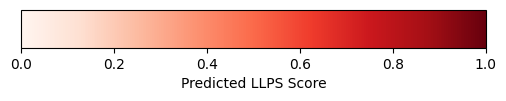

In [ ]:
#@title plot
import matplotlib.pyplot as plt
import streamlit as st
from stmol import showmol
import py3Dmol
import requests
import biotite.structure.io as bsio
import certifi
import matplotlib.colors as mcolors
import urllib3

if Plot == True and Sequence != "" and Sequence != None:
  fig1.show()


  urllib3.disable_warnings()

  st.sidebar.title('🎈 ESMFold')
  st.sidebar.write('[*ESMFold*](https://esmatlas.com/about) is an end-to-end single sequence protein structure predictor based on the ESM-2 language model. For more information, read the [research article](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v2) and the [news article](https://www.nature.com/articles/d41586-022-03539-1) published in *Nature*.')

  def render_mol(pdb):
    pdbview = py3Dmol.view()
    pdbview.addModel(pdb, 'pdb')
    pdbview.setStyle({'cartoon': {'color': 'spectrum'}})
    pdbview.setBackgroundColor('white')  # ('0xeeeeee')
    pdbview.zoomTo()
    pdbview.zoom(2, 800)
    pdbview.spin(True)
    showmol(pdbview, height=500, width=800)


  DEFAULT_SEQ = Sequence
  show_mainchains = False #@param {type: "boolean"}
  show_sidechains = False #@param {type: "boolean"}
  Color_Style =  "red_blue_spectrum" #@param ["red_blue_spectrum","green_magenta_spectrum","yellow_blue_spectrum","cyan_red_spectrum"]

  import streamlit as st
  import requests
  import biotite.structure.io as bsio
  import py3Dmol

  DEFAULT_SEQ = Sequence

  txt = st.sidebar.text_area('Input sequence', DEFAULT_SEQ, height=275)

  def update(sequence,name):
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
    }

    def get_pdb(sequence):
        response = requests.post('https://api.esmatlas.com/foldSequence/v1/pdb/', headers=headers, data=sequence, verify=False)
        if response.status_code != 200:
            st.error(f"Failed to get prediction: {response.status_code}")
            return None
        pdb_string = response.content.decode('utf-8')
        if not pdb_string or "ATOM" not in pdb_string:
            st.error("Received an invalid PDB file.")
            return None
        return pdb_string

    def save_and_render_pdb(pdb_string, file_name):
        with open(file_name, 'w') as f:
            f.write(pdb_string)
        try:
            struct = bsio.load_structure(file_name, extra_fields=["b_factor"])
            b_value = round(struct.b_factor.mean(), 4)
        except Exception as e:
            st.error(f"Error loading structure: {e}")
            return
        st.subheader('Visualization of predicted protein structure')
        render_mol(pdb_string)
        st.subheader('plDDT')
        st.write('plDDT is a per-residue estimate of the confidence in prediction on a scale from 0-100.')
        st.info(f'plDDT: {b_value}')
        st.download_button(label="Download PDB", data=pdb_string, file_name=file_name, mime='text/plain')

    def render_mol(pdb_string,neme):
        view = py3Dmol.view(width=1000, height=800)
        view.addModel(pdb_string, 'pdb')
        F1 = Get_color(p)
        F1.i = F1.J.index(Color_Style)

        custom_colors=F1.spectrum()

        for i, color in enumerate(custom_colors[1:-1]):
          view.setStyle({ 'resi': i+1}, {'cartoon': {'color': color}})
        #view.setStyle({'cartoon': {'color': 'spectrum'}})
        view.zoomTo()
        view.show()
        html_content = view._make_html()
        with open(name+'.html', 'w') as file:
          file.write(html_content)
        files.download(name+'.html')


    chunk_size = 400
    chunks = [sequence[i:i + chunk_size] for i in range(0, len(sequence), chunk_size)]

    combined_pdb_string = ""
    for i, chunk in enumerate(chunks):
        st.write(f"Processing chunk {i + 1} of {len(chunks)}")
        pdb_string = get_pdb(chunk)
        if pdb_string:
            combined_pdb_string += pdb_string

    if combined_pdb_string:
        render_mol(combined_pdb_string,name)
        with open('combined_predicted.pdb', 'w') as f:
            f.write(combined_pdb_string)
        st.download_button(label="Download Combined PDB", data=combined_pdb_string, file_name='combined_predicted.pdb', mime='text/plain')
  predict = st.sidebar.button('Predict', on_click=update)

  if not predict:
    st.warning('👈 Enter protein sequence data!')

  class Get_color():
    def __init__(self,values):
      self.J = ["red_blue_spectrum","green_magenta_spectrum","yellow_blue_spectrum","cyan_red_spectrum"]
      self.i = None
      self.values = values

    def get_red_blue_spectrum(self,values):
      norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
      cmap = mcolors.LinearSegmentedColormap.from_list("RedBlue", ["blue", "red"])
      spectrum = [mcolors.to_hex(cmap(norm(value))) for value in values]
      return spectrum

    def get_green_magenta_spectrum(self,values):
      norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
      cmap = mcolors.LinearSegmentedColormap.from_list("GreenMagenta", ["green", "magenta"])
      spectrum = [mcolors.to_hex(cmap(norm(value))) for value in values]
      return spectrum
    def get_yellow_blue_spectrum(self,values):
      norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
      cmap = mcolors.LinearSegmentedColormap.from_list("YellowBlue", ["yellow", "blue"])
      spectrum = [mcolors.to_hex(cmap(norm(value))) for value in values]
      return spectrum


    def get_cyan_red_spectrum(self,values):
      norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
      cmap = mcolors.LinearSegmentedColormap.from_list("CyanRed", ["cyan", "red"])
      spectrum = [mcolors.to_hex(cmap(norm(value))) for value in values]
      return spectrum

    def spectrum(self):
      if self.i == 0 : return self.get_red_blue_spectrum(self.values)
      if self.i == 1 : return self.get_green_magenta_spectrum(self.values)
      if self.i == 2 : return self.get_yellow_blue_spectrum(self.values)
      if self.i == 3 : return self.get_cyan_red_spectrum(self.values)
  update(txt,"A")


# Create a color bar legend using matplotlib
  fig, ax = plt.subplots(figsize=(6, 1))
  fig.subplots_adjust(bottom=0.5)

  cmap = plt.cm.Reds
  norm = mcolors.Normalize(vmin=0, vmax=1)
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal', label='Predicted LLPS Score')
  plt.show()







In [ ]:
#@title Downloading the results`

if os.path.exists("d"):
    !rm -rf "d"
if os.path.exists("text_dir"):
    !rm -rf "text_dir"

!mkdir text_dir
!mkdir d
c = PPA(Sequence , model3)
if Sequence != None and Sequence !="" :
  if ID == None:
    c.name = "Your peptide"
  with open("seq.txt","w") as w:
          w.write("                                                 <<<<<<  LLPS prediction results  >>>>>>\n\n\n")
          w.write("[Sequence id] : " +c.name+"\n\n")
          w.write("[Sequence length] : "+str(len(c.seq))+"\n\n")
          w.write("[Sequence_of_peptide] : " +c.seq+"\n\n")
          w.write("[Predicted_score] : " +score +"\n\n")
          w.close()



  if c.name != None:
    img_name = "Info_of_sequenceID:"+c.name+".png"
    fig1.write_image(img_name)
  else:
    name = np.random.randint(1000000)
    img_name = "Info_of_sequenceID:"+str(name)+".png"
    fig1.write_image(img_name)

  shutil.move(img_name, "d")
  shutil.move("seq.txt", "text_dir")
  text_files_path = "text_dir"
  png_files_path = "d"

  zip_output_path = 'zipped_files.zip'

  text_files = [f for f in os.listdir(text_files_path) if f.endswith('.txt')]
  png_files = [f for f in os.listdir(png_files_path) if f.endswith('.png')]

  with zipfile.ZipFile(zip_output_path, 'w') as zipf:
    for text_file in text_files:
      zipf.write(os.path.join(text_files_path, text_file), arcname=text_file)

    for png_file in png_files:
      zipf.write(os.path.join(png_files_path, png_file), arcname=png_file)

  print("Files zipped successfully!")


else:
  h = pd.DataFrame(D)
  h.to_json("h.json")
  with open("results.txt","w") as w:
    w.write("                                                 <<<<<<  LLPS prediction results  >>>>>>\n\n\n")
    w.write("Number of sequences : "+str(len(D["seq"]))+"\n\n")
    for i in range(len(D["id"])):
      w.write(" [Sequence {i}]".format(i = i)+"\n\n")
      w.write("   Sequence id : "+D["id"][i]+"\n\n")
      w.write("   Sequence length : "+str(len(D["seq"][i]))+"\n\n")
      w.write("   Sequence : " + D["seq"][i]+"\n\n")
      w.write("   Predicted Score : " + str(D["score"][i])+"\n\n")
      w.write("-"*150+"\n\n")
    w.close()
    shutil.move("h.json", "d")
    shutil.move("results.txt", "text_dir")
    text_files_path = "text_dir"
    png_files_path = "d"
    zip_output_path = 'zipped_files.zip'

    text_files = [f for f in os.listdir(text_files_path) if f.endswith('.txt')]
    png_files = [f for f in os.listdir(png_files_path) if f.endswith('.json')]

    with zipfile.ZipFile(zip_output_path, 'w') as zipf:
      for text_file in text_files:
        zipf.write(os.path.join(text_files_path, text_file), arcname=text_file)

      for png_file in png_files:
        zipf.write(os.path.join(png_files_path, png_file), arcname=png_file)

    print("Files zipped successfully!")

files.download("zipped_files.zip")




Files zipped successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##NCBI BLAST+
To determine the BLAST database, you can either provide a FASTA file path to create your own database or use the URL link to NCBI's protein databases available on the NCBI page: https://ftp.ncbi.nlm.nih.gov/blast/db/

The DrLLPS database has already been provided. By setting the Blast_Database to DrLLPS, the BLAST search will be conducted against the DrLLPS database.

To load your sequences, you can either input a single sequence or upload a FASTA format file containing your sequences into the designated box

as example :
  **MAVRVAKMTEREKLLLKKYGNRRLYDTKRSAYVTLSQVADIIKQGVDVEVVDAKTQEDVTAFILTQIVLEQARRKNALLPAELLHLIIRYGEDLLQEFFQKYLEQTIHGYIQFKKAMDEQFSKWIDMQLNYSDMAHKTLSGLTRFPNIFSPPPGSPGTKKDKG**

or

**Your_file.fasta**



In [ ]:
#@title BLAST+ Tool


import os
#@markdown - Specify the sequence or the path of your FASTA format file in this box : like  `MAVRVAKMTEREKLL`  or `Your_file.fasta`

Sequence = "MAVRVAKMTEREKLLLKKYGNRRLYDTKRSAYVTLSQVADIIKQGVDVEVVDAKTQEDVTAFILTQIVLEQARRKNALLPAELLHLIIRYGEDLLQEFFQKYLEQTIHGYIQFKKAMDEQFSKWIDMQLNYSDMAHKTLSGLTRFPNIFSPPPGSPGTKKDKG" #@param {type:"string"}
#@markdown - Specify the fasta file or URL of your Database here :                    like  `https://ftp.ncbi.nlm.nih.gov/blast/db/swissprot.tar.gz`  or `Your_Database.fasta`

Blast_Database = "DrLLPS" #@param ["DrLLPS","https://ftp.ncbi.nlm.nih.gov/blast/db/FASTA/swissprot.gz"] {allow-input : true}
Blast_result_format = "1" #@param [1,2,3,4,5,6,7]
Blast_result_file_name = "Blast_result.txt" #@param {type:"string"}
E_value_threshold = "100" #@param {type:"string"}
Max_target_Sequences = 6 #@param {type:"integer"}

if Blast_Database == "DrLLPS":
  Blast_Database = "DrLLPS.fasta"

import sys
from os import path

if path.exists("/content/bioinformatics_stockholm/"):
  pass
else:
  !git clone https://github.com/Intertangler/bioinformatics_stockholm
sys.path.insert(0,'/content')

import importlib.util
spec = importlib.util.spec_from_file_location("msa", "/content/bioinformatics_stockholm/msa/msa.py")
msa = importlib.util.module_from_spec(spec)
spec.loader.exec_module(msa)

spec = importlib.util.spec_from_file_location("miniblast", "/content/bioinformatics_stockholm/Miniblast/miniblast.py")
miniblast = importlib.util.module_from_spec(spec)
spec.loader.exec_module(miniblast)

def Fasta(fasta_path):
  from command_runner import command_runner
  command = "makeblastdb -in {k} -dbtype prot -out blastdb".format(k =fasta_path )
  exit_code, output = command_runner(command, shell=True, live_output=True)
  print("-- Blast Database has been created -- \n")


if ".fasta" in Blast_Database or ".txt" in Blast_Database:
  if os.path.exists(Blast_Database):
    Fasta(Blast_Database)
  with open(Blast_Database) as w:
    j = w.read().split(">")[1:]
  Dict = {i[:i.index("\n")].split(" ")[0] if "\n" in i else i : edit(i[i.index("\n"):]) if "\n" in i else None for i in j}

else:
  command = "wget {k}".format(k = Blast_Database)
  exit_code, output = command_runner(command, shell=True, live_output=True)
  print("-- Blast Database has been downloaded -- \n")
  exit_code, output = command_runner("gunzip {l}".format(l = Blast_Database.split("/")[-1]), shell=True, live_output=True)
  Fasta(Blast_Database.split("/")[-1][:-3])
  db = miniblast.read_database_fasta(Blast_Database.split("/")[-1][:-3])
  Dict = {i.id :"".join(list(i.seq)) for i in db}


Cloning into 'bioinformatics_stockholm'...
remote: Enumerating objects: 296, done.
remote: Total 296 (delta 0), reused 0 (delta 0), pack-reused 296 (from 1)
Receiving objects: 100% (296/296), 42.10 MiB | 21.85 MiB/s, done.
Resolving deltas: 100% (127/127), done.


Building a new DB, current time: 08/29/2024 11:53:18
New DB name:   /content/blastdb
New DB title:  DrLLPS.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1272 sequences in 0.0364358 seconds.


-- Blast Database has been created -- 



In [ ]:
#@title Blast Result

blosum62 = {
    ('W', 'F'): 1, ('L', 'R'): -2, ('S', 'P'): -1, ('V', 'T'): 0,
    ('Q', 'Q'): 5, ('N', 'A'): -2, ('Z', 'Y'): -2, ('W', 'R'): -3,
    ('Q', 'A'): -1, ('S', 'D'): 0, ('H', 'H'): 8, ('S', 'H'): -1,
    ('H', 'D'): -1, ('L', 'N'): -3, ('W', 'A'): -3, ('Y', 'M'): -1,
    ('G', 'R'): -2, ('Y', 'I'): -1, ('Y', 'E'): -2, ('B', 'Y'): -3,
    ('Y', 'A'): -2, ('V', 'D'): -3, ('B', 'S'): 0, ('Y', 'Y'): 7,
    ('G', 'N'): 0, ('E', 'C'): -4, ('Y', 'Q'): -1, ('Z', 'Z'): 4,
    ('V', 'A'): 0, ('C', 'C'): 9, ('M', 'R'): -1, ('V', 'E'): -2,
    ('T', 'N'): 0, ('P', 'P'): 7, ('V', 'I'): 3, ('V', 'S'): -2,
    ('Z', 'P'): -1, ('V', 'M'): 1, ('T', 'F'): -2, ('V', 'Q'): -2,
    ('K', 'K'): 5, ('P', 'D'): -1, ('I', 'H'): -3, ('I', 'D'): -3,
    ('T', 'R'): -1, ('P', 'L'): -3, ('K', 'G'): -2, ('M', 'N'): -2,
    ('P', 'H'): -2, ('F', 'Q'): -3, ('Z', 'G'): -2, ('X', 'L'): -1,
    ('T', 'M'): -1, ('Z', 'C'): -3, ('X', 'H'): -1, ('D', 'R'): -2,
    ('B', 'W'): -4, ('X', 'D'): -1, ('Z', 'K'): 1, ('F', 'A'): -2,
    ('Z', 'W'): -3, ('F', 'E'): -3, ('D', 'N'): 1, ('B', 'K'): 0,
    ('X', 'X'): -1, ('F', 'I'): 0, ('B', 'G'): -1, ('X', 'T'): 0,
    ('F', 'M'): 0, ('B', 'C'): -3, ('Z', 'I'): -3, ('Z', 'V'): -2,
    ('S', 'S'): 4, ('L', 'Q'): -2, ('W', 'E'): -3, ('Q', 'R'): 1,
    ('N', 'N'): 6, ('W', 'M'): -1, ('Q', 'C'): -3, ('W', 'I'): -3,
    ('S', 'C'): -1, ('L', 'A'): -1, ('S', 'G'): 0, ('L', 'E'): -3,
    ('W', 'Q'): -2, ('H', 'G'): -2, ('S', 'K'): 0, ('Q', 'N'): 0,
    ('N', 'R'): 0, ('H', 'C'): -3, ('Y', 'N'): -2, ('G', 'Q'): -2,
    ('Y', 'F'): 3, ('C', 'A'): 0, ('V', 'L'): 1, ('G', 'E'): -2,
    ('G', 'A'): 0, ('K', 'R'): 2, ('E', 'D'): 2, ('Y', 'R'): -2,
    ('M', 'Q'): 0, ('T', 'I'): -1, ('C', 'D'): -3, ('V', 'F'): -1,
    ('T', 'A'): 0, ('T', 'P'): -1, ('B', 'P'): -2, ('T', 'E'): -1,
    ('V', 'N'): -3, ('P', 'G'): -2, ('M', 'A'): -1, ('K', 'H'): -1,
    ('V', 'R'): -3, ('P', 'C'): -3, ('M', 'E'): -2, ('K', 'L'): -2,
    ('V', 'V'): 4, ('M', 'I'): 1, ('T', 'Q'): -1, ('I', 'G'): -4,
    ('P', 'K'): -1, ('M', 'M'): 5, ('K', 'D'): -1, ('I', 'C'): -1,
    ('Z', 'D'): 1, ('F', 'R'): -3, ('X', 'K'): -1, ('Q', 'D'): 0,
    ('X', 'G'): -1, ('Z', 'L'): -3, ('X', 'C'): -2, ('Z', 'H'): 0,
    ('B', 'L'): -4, ('B', 'H'): 0, ('F', 'F'): 6, ('X', 'W'): -2,
    ('B', 'D'): 4, ('D', 'A'): -2, ('S', 'L'): -2, ('X', 'S'): 0,
    ('F', 'N'): -3, ('S', 'R'): -1, ('W', 'D'): -4, ('V', 'Y'): -1,
    ('W', 'L'): -2, ('H', 'R'): 0, ('W', 'H'): -2, ('H', 'N'): 1,
    ('W', 'T'): -2, ('T', 'T'): 5, ('S', 'F'): -2, ('W', 'P'): -4,
    ('L', 'D'): -4, ('B', 'I'): -3, ('L', 'H'): -3, ('S', 'N'): 1,
    ('B', 'T'): -1, ('L', 'L'): 4, ('Y', 'K'): -2, ('E', 'Q'): 2,
    ('Y', 'G'): -3, ('Z', 'S'): 0, ('Y', 'C'): -2, ('G', 'D'): -1,
    ('B', 'V'): -3, ('E', 'A'): -1, ('Y', 'W'): 2, ('E', 'E'): 5,
    ('Y', 'S'): -2, ('C', 'N'): -3, ('V', 'C'): -1, ('T', 'H'): -2,
    ('P', 'R'): -2, ('V', 'G'): -3, ('T', 'L'): -1, ('V', 'K'): -2,
    ('K', 'Q'): 1, ('R', 'A'): -1, ('I', 'R'): -3, ('T', 'D'): -1,
    ('P', 'F'): -4, ('I', 'N'): -3, ('K', 'I'): -3, ('M', 'D'): -3,
    ('V', 'W'): -3, ('W', 'W'): 11, ('M', 'H'): -2, ('P', 'N'): -2,
    ('K', 'A'): -1, ('M', 'L'): 2, ('K', 'E'): 1, ('Z', 'E'): 4,
    ('X', 'N'): -1, ('Z', 'A'): -1, ('Z', 'M'): -1, ('X', 'F'): -1,
    ('K', 'C'): -3, ('B', 'Q'): 0, ('X', 'B'): -1, ('B', 'M'): -3,
    ('F', 'C'): -2, ('Z', 'Q'): 3, ('X', 'Z'): -1, ('F', 'G'): -3,
    ('B', 'E'): 1, ('X', 'V'): -1, ('F', 'K'): -3, ('B', 'A'): -2,
    ('X', 'R'): -1, ('D', 'D'): 6, ('W', 'G'): -2, ('Z', 'F'): -3,
    ('S', 'Q'): 0, ('W', 'C'): -2, ('W', 'K'): -3, ('H', 'Q'): 0,
    ('L', 'C'): -1, ('W', 'N'): -4, ('S', 'A'): 1, ('L', 'G'): -4,
    ('W', 'S'): -3, ('S', 'E'): 0, ('H', 'E'): 0, ('S', 'I'): -2,
    ('H', 'A'): -2, ('S', 'M'): -1, ('Y', 'L'): -1, ('Y', 'H'): 2,
    ('Y', 'D'): -3, ('E', 'R'): 0, ('X', 'P'): -2, ('G', 'G'): 6,
    ('G', 'C'): -3, ('E', 'N'): 0, ('Y', 'T'): -2, ('Y', 'P'): -3,
    ('T', 'K'): -1, ('A', 'A'): 4, ('P', 'Q'): -1, ('T', 'C'): -1,
    ('V', 'H'): -3, ('T', 'G'): -2, ('I', 'Q'): -3, ('Z', 'T'): -1,
    ('C', 'R'): -3, ('V', 'P'): -2, ('P', 'E'): -1, ('M', 'C'): -1,
    ('K', 'N'): 0, ('I', 'I'): 4, ('P', 'A'): -1, ('M', 'G'): -3,
    ('T', 'S'): 1, ('I', 'E'): -3, ('P', 'M'): -2, ('M', 'K'): -1,
    ('I', 'A'): -1, ('P', 'I'): -3, ('R', 'R'): 5, ('X', 'M'): -1,
    ('L', 'I'): 2, ('X', 'I'): -1, ('Z', 'B'): 1, ('X', 'E'): -1,
    ('Z', 'N'): 0, ('X', 'A'): 0, ('B', 'R'): -1, ('B', 'N'): 3,
    ('F', 'D'): -3, ('X', 'Y'): -1, ('Z', 'R'): 0, ('F', 'H'): -1,
    ('B', 'F'): -3, ('F', 'L'): 0, ('X', 'Q'): -1, ('B', 'B'): 4
}

Blosum62 = {}
for i in blosum62:
  Blosum62[i] = blosum62[i]
  Blosum62[i[::-1]] = blosum62[i]
if "." not in Sequence:
  with open("sequence.txt","w") as w:
    w.write(">seq1\n{o}".format(o = Sequence))
    w.close()
  command = "blastp -query {q} -db blastdb -out {o} -outfmt {f} -max_target_seqs {m} -evalue {e}".format(q = "sequence.txt",d = "blastdb"
  ,f = Blast_result_format,o = Blast_result_file_name , m = Max_target_Sequences , e = E_value_threshold)
  exit_code, output = command_runner(command, shell=True, live_output=True)
  files.download(Blast_result_file_name)
  command = "blastp -query {q} -db blastdb -out {o} -outfmt {f} -max_target_seqs {m} -evalue {e}".format(q = "sequence.txt",d = "blastdb"
  ,f = 6 ,o = "results_dict.txt" , m = Max_target_Sequences , e = E_value_threshold)
  exit_code, output = command_runner(command, shell=True, live_output=True)

  with open("results_dict.txt") as w:
    y = w.read()
  idx = [i.split("\t")[1] for i in y.split("\nseq")]
  for i in idx:
    target_sequence = Dict[i]
    aln = pairwise2.align.localds(Sequence,target_sequence, match_dict = Blosum62, open = -3, extend = -1)[0]
    print("Subject_Id : "+i+"\n")
    print(pairwise2.format_alignment(align1=aln[0], align2=aln[1], score=aln[2], begin=aln[3], end=aln[4], full_sequences=True))






if "." in Sequence:
  command = "blastp -query {q} -db blastdb -out {o} -outfmt {f} -max_target_seqs {m} -evalue {e}".format(q = Sequence,d = "blastdb"
  ,f = Blast_result_format,o = Blast_result_file_name , m = Max_target_Sequences , e = E_value_threshold)
  exit_code, output = command_runner(command, shell=True, live_output=True)
  files.download(Blast_result_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subject_Id : seq925

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------MAVRVAKMTEREKLLLKKYG--NRRL------YDTKRSAY----VTLSQ--VADIIKQGVD-V-EVVDAKTQEDVTAF-ILTQIVLEQARRKNALLPAEL--L----HLIIRYGE-DLLQEFFQKYLEQTIHGYIQFKKAMDEQFSKWIDMQLNYSDMAHKT-LSGLTRFPNIFSPPPGSP-GTKKDKG---------------------------------------------------------------------------------------------------------------
                                                                                                                                                                            